In [38]:
import torch 
import cv2
import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp

from tqdm import tqdm
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch import nn


In [39]:
BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / 'segmentationData'

In [40]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 5
LR = 0.001
IMG_SIZE = 512
BATCH_SIZE = 6
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'
MODEL_NAME = f'{EPOCHS}_best_model.pt'

In [41]:
def addPaths(row, DATA_DIR):
    if row.test:
        image_path = str(DATA_DIR / 'test'/ 'images' / row.images)
        mask_path = str(DATA_DIR / 'test'/ 'ground_truth' / row.masks)
    else:
        image_path = str(DATA_DIR / 'training'/ 'images' / row.images)
        mask_path = str(DATA_DIR / 'training'/ 'ground_truth' / row.masks)
    return image_path, mask_path

masterDf = pd.read_csv(DATA_DIR / 'key.csv')
masterDf[['image_path', 'mask_path']] = masterDf.apply(lambda x: addPaths(x, DATA_DIR), axis=1, result_type='expand')

train_df = masterDf[masterDf['ttv']==0]
valid_df = masterDf[masterDf['ttv']==1]
test_df = masterDf[masterDf['ttv']==2]

In [42]:
def get_train_augs():
    return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE),
                      A.HorizontalFlip(p=0.5),
                      A.VerticalFlip(p=0.5),
                      A.Sharpen(p=1)])
                     
def get_test_augs():
    return A.Compose([A.Resize(IMG_SIZE, IMG_SIZE)])

In [43]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row.image_path
        mask_path = row.mask_path

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2,0,1)).astype(np.float)
        mask = np.transpose(mask, (2,0,1)).astype(np.float)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [44]:
# Load the datasets into Torch Dataset 
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_test_augs())
testset = SegmentationDataset(test_df, get_test_augs())

print(f"Trainset batches: {len(trainset)}")
print(f"Validset batches: {len(validset)}")
print(f"Testset batches: {len(testset)}")

Trainset batches: 30
Validset batches: 5
Testset batches: 5


C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


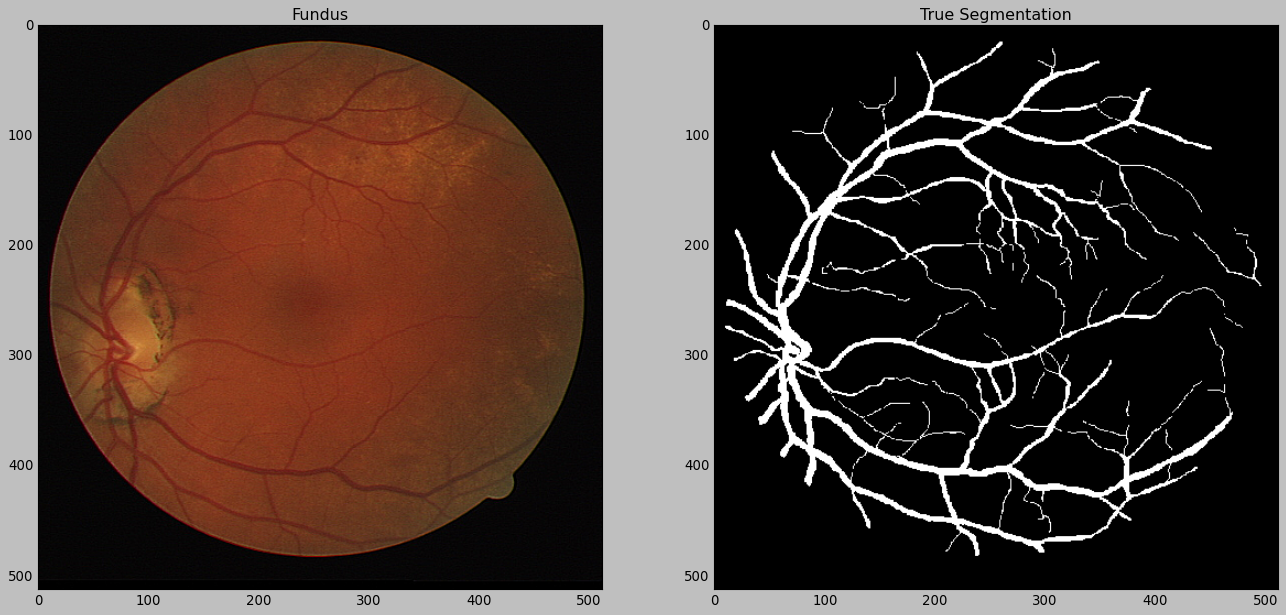

In [45]:
# Display an image-mask pair
def displayMasks(image, mask, pred = None, path=None, epoch=None, show=False):
    plt.style.use('classic')
    if pred == None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
        ax1.set_title('Fundus')
        ax2.set_title('True Segmentation')
        
        if show:
            ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
            ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred != None:
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
        
        ax1.set_title('Fundus')
        ax2.set_title('True Segmentation')
        
        modelTitle = 'Predicted Segmentation'
        if epoch != None:
            modelTitle += f' {epoch}'
        ax3.set_title(modelTitle)
        
        if show:
            ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
            ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
            ax3.imshow(pred.permute(1,2,0).squeeze(),cmap = 'gray')
        
    if path != None:
        f.savefig(path+".png", dpi=300)

image, mask = trainset[5]
displayMasks(image, mask, show=True)

In [46]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

In [47]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.arc =  smp.Unet(encoder_name = ENCODER,
                            encoder_weights = WEIGHTS,
                            in_channels = 3,
                            classes = 1,
                            activation = None)
    
    def forward(self, images, masks=None):
        logits = self.arc(images)
        if masks != None:
            bce = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, bce
        return logits

model = SegmentationModel().to(DEVICE)

In [48]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in data_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

trainL = []
validL = []

# Train the model
for i in tqdm(range(EPOCHS)):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
    
    trainL.append(train_loss)
    validL.append(valid_loss)

    torch.save(model.state_dict(), f'segmentationData/models/bcedice_{i}_{MODEL_NAME}')


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


[]


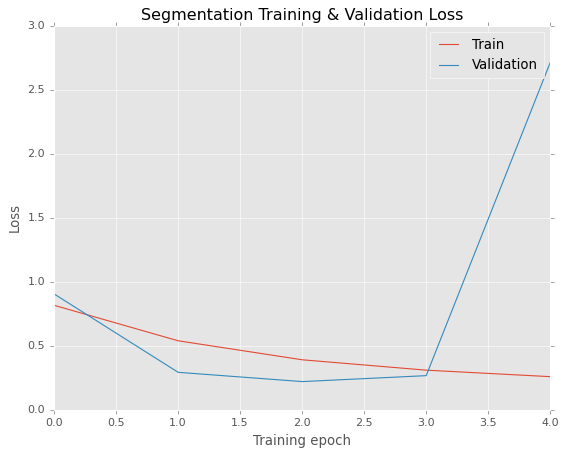

In [51]:
def plotLosses(df):
    plt.style.use("ggplot")
    plt.plot(df.epoch, df.train_loss, label='Train')
    plt.plot(df.epoch, df.valid_loss, label='Validation')
    plt.title('Segmentation Training & Validation Loss')
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

lossDf = pd.DataFrame({'epoch':[i for i in range(len(trainL))],
                       'train_loss':trainL,
                       'valid_loss':validL})
plotLosses(lossDf)

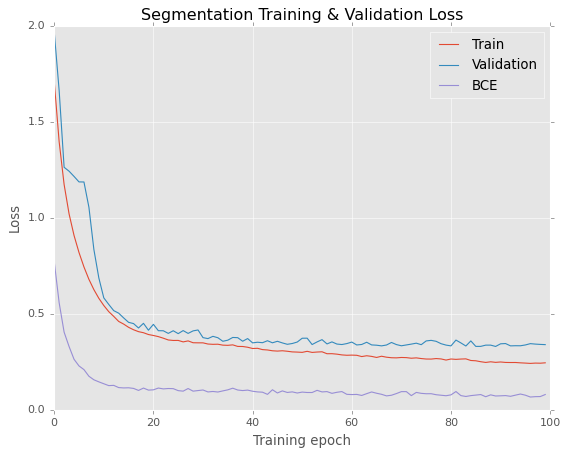

In [52]:
def plotLosses(df):
    plt.style.use("ggplot")
    plt.plot(df.epoch, df.train_loss, label='Train')
    plt.plot(df.epoch, df.valid_loss, label='Validation')
    plt.plot(df.epoch, df.bce, label='BCE')
    plt.title('Segmentation Training & Validation Loss')
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

lossDf = pd.read_csv('segmentationData/results/bcedice.csv')
plotLosses(lossDf)

C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(3.2864)
tensor(861500.)


C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(3.1258)
tensor(819400.)


C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(3.5213)
tensor(923100.)


C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(3.6514)
tensor(957200.)


C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\hanse\anaconda3\envs\torch2\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


tensor(3.9726)
tensor(1041400.)


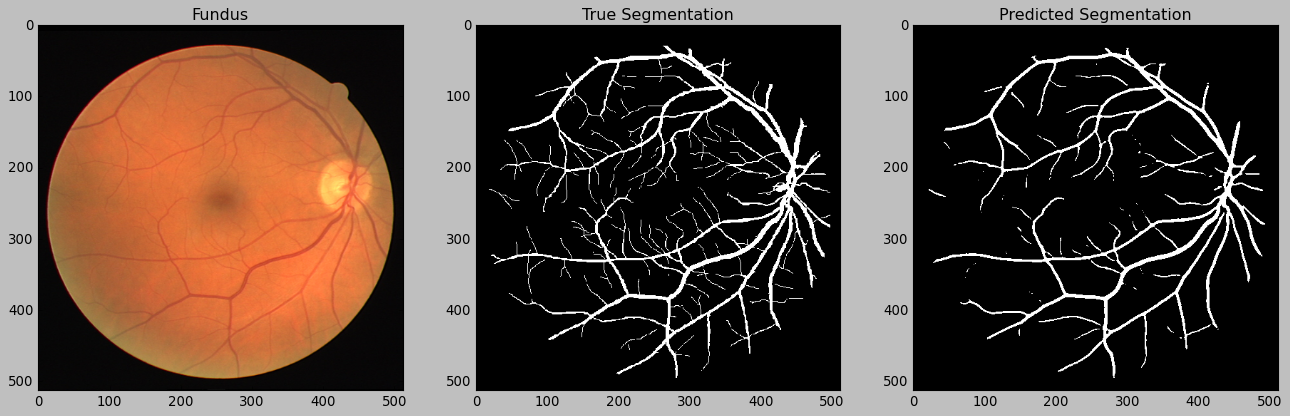

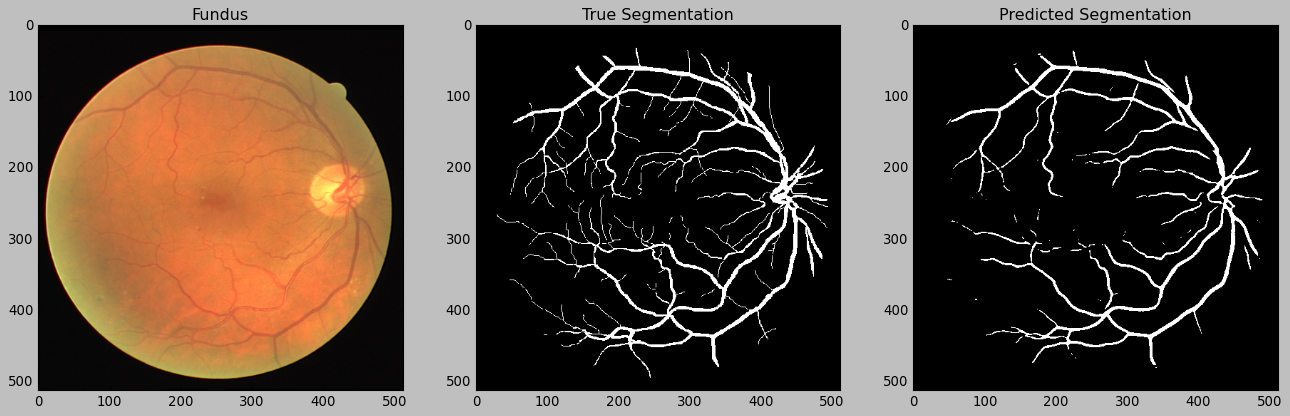

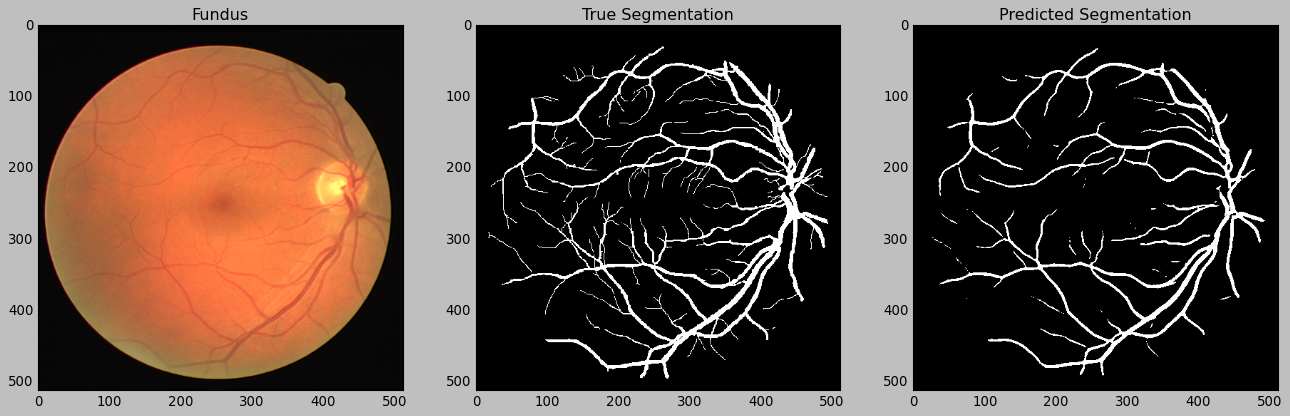

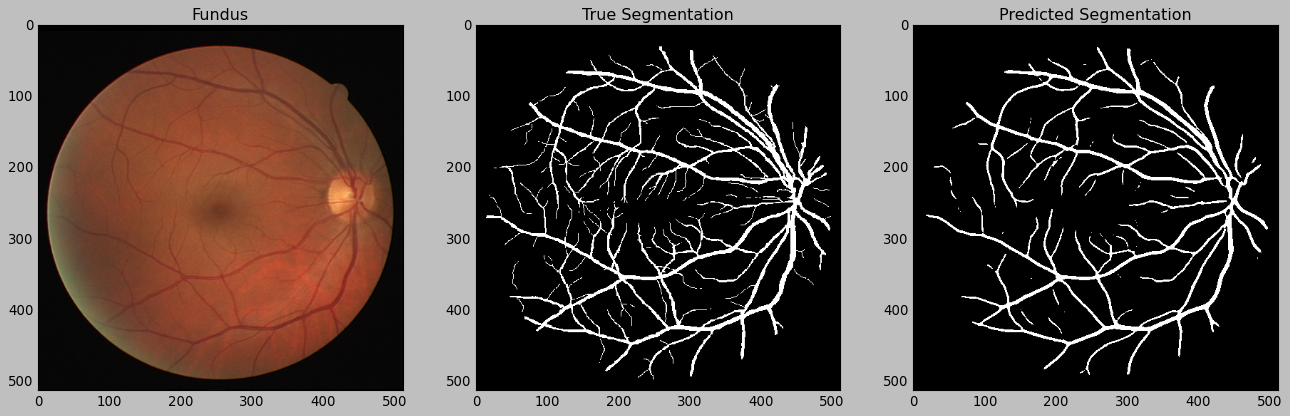

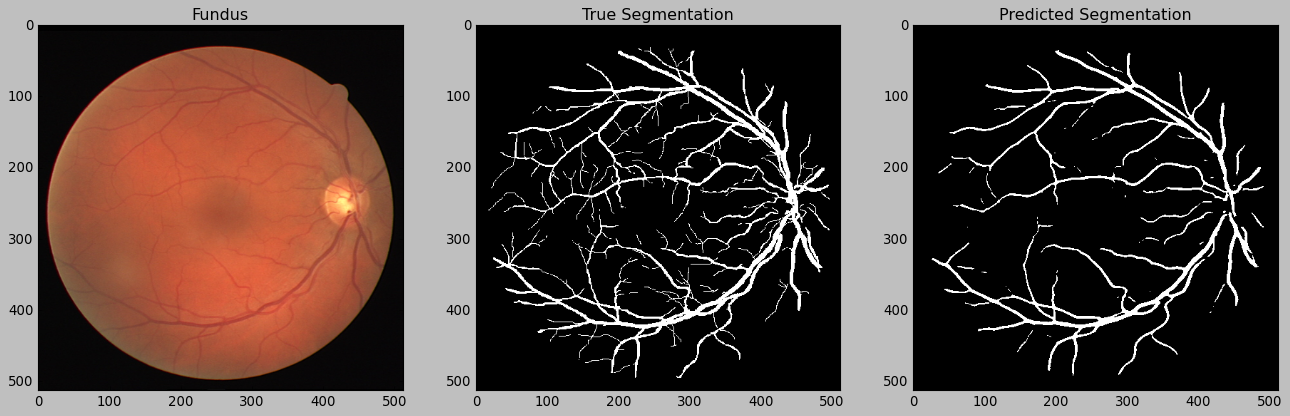

In [53]:
model.load_state_dict(torch.load(f'segmentationData/models/bce_40_100_best_model.pt'))

ces = []
for i in range(len(testset)):
    image, mask = testset[i]
    logits_mask = model(image.to(DEVICE).unsqueeze(0))
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5) * 1.0
    preds = pred_mask.to('cpu').squeeze(0)
    displayMasks(image, mask, pred_mask.detach().cpu().squeeze(0), path=f'segmentationData/results/result_{i}', show=True)